In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")


In [3]:
orders = pd.read_csv('../data/olist_orders_dataset.csv')
items = pd.read_csv('../data/olist_order_items_dataset.csv')
products = pd.read_csv('../data/olist_products_dataset.csv')
payments = pd.read_csv('../data/olist_order_payments_dataset.csv')
reviews = pd.read_csv('../data/olist_order_reviews_dataset.csv')
customers = pd.read_csv('../data/olist_customers_dataset.csv')
sellers = pd.read_csv('../data/olist_sellers_dataset.csv')
category_translation = pd.read_csv('../data/product_category_name_translation.csv')


In [4]:
#1. Join Orders with items using order id which is common
# Inner join because without item there's no meaning of order
df = pd.merge(orders, items, on='order_id', how='inner')

#2. Join Products details where product id is common
df = pd.merge(df, products, on='product_id', how='left')

#3. Get Product Category in English where currently it's in portugese
df = pd.merge(df, category_translation, on='product_category_name', how='left')

#4. Add Reviews where Order id is common
df = pd.merge(df, reviews, on='order_id', how='left')

#5. Add Customers using customer_id
df = pd.merge(df, customers, on='customer_id', how='left')

#Print Data and its shape
print(f'Final Data Shape: {df.shape}')
df.info()


Final Data Shape: (113314, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113314 entries, 0 to 113313
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113314 non-null  object 
 1   customer_id                    113314 non-null  object 
 2   order_status                   113314 non-null  object 
 3   order_purchase_timestamp       113314 non-null  object 
 4   order_approved_at              113299 non-null  object 
 5   order_delivered_carrier_date   112111 non-null  object 
 6   order_delivered_customer_date  110839 non-null  object 
 7   order_estimated_delivery_date  113314 non-null  object 
 8   order_item_id                  113314 non-null  int64  
 9   product_id                     113314 non-null  object 
 10  seller_id                      113314 non-null  object 
 11  shipping_limit_date            113314 non-null  object 
 12 

In [5]:
# Convert Date Columns

date_cols = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','shipping_limit_date','review_creation_date','review_answer_timestamp']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

print(df[date_cols].dtypes)


order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
shipping_limit_date              datetime64[ns]
review_creation_date             datetime64[ns]
review_answer_timestamp          datetime64[ns]
dtype: object


In [6]:
df.order_status.unique()


array(['delivered', 'invoiced', 'shipped', 'processing', 'canceled',
       'unavailable', 'approved'], dtype=object)

In [7]:
#1. Keep Delivered Ordered only using order_status
df = df[df.order_status == 'delivered']

#2. Feature engineering: Time Duration (Actual Time/How much actual time took to deliver product to customer)
df['delivery_days'] = (df.order_delivered_customer_date - df.order_purchase_timestamp).dt.days

# Estimated Delivery Time / How Much time we have promissed to deliver the product
df['estimated_days'] = (df.order_estimated_delivery_date - df.order_purchase_timestamp).dt.days

# Difference Betweel Estimated Delivery Date and Actual Delivery Date
df['arrival_time_diff'] = (df.order_estimated_delivery_date - df.order_delivered_customer_date).dt.days

# Binary Feature for Delivery Late (1: Late Delivery, 0: On Time)
df['is_late'] = (df.order_delivered_customer_date > df.order_estimated_delivery_date).astype(int)

# Missing value handle (Product Category Missing then fill Unknown)
df.product_category_name_english = df.product_category_name_english.fillna('Unknown')

# Print Modification
print(f"New Shape after filtering: {df.shape}")
df[['delivery_days', 'estimated_days', 'arrival_time_diff', 'is_late', 'product_category_name_english']].head()


New Shape after filtering: (110840, 37)


,delivery_days,estimated_days,arrival_time_diff,is_late,product_category_name_english
0,8.0,15,7.0,0,housewares
1,13.0,19,5.0,0,perfumery
2,9.0,26,17.0,0,auto
3,13.0,26,12.0,0,pet_shop
4,2.0,12,9.0,0,stationery


In [8]:
df.order_status.unique()


array(['delivered'], dtype=object)

In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 110840 entries, 0 to 113313
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110840 non-null  object        
 1   customer_id                    110840 non-null  object        
 2   order_status                   110840 non-null  object        
 3   order_purchase_timestamp       110840 non-null  datetime64[ns]
 4   order_approved_at              110825 non-null  datetime64[ns]
 5   order_delivered_carrier_date   110838 non-null  datetime64[ns]
 6   order_delivered_customer_date  110832 non-null  datetime64[ns]
 7   order_estimated_delivery_date  110840 non-null  datetime64[ns]
 8   order_item_id                  110840 non-null  int64         
 9   product_id                     110840 non-null  object        
 10  seller_id                      110840 non-null  object        
 11  shipp

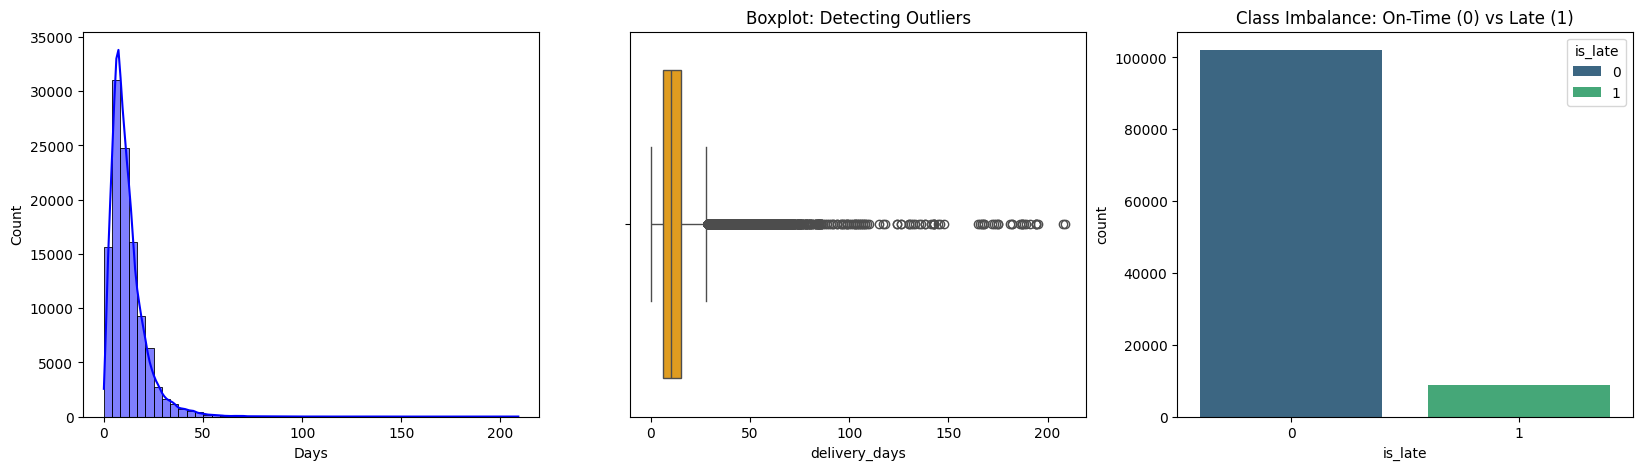

Skewness of Delivery Days: 3.827207046215916

Late vs On-Time Counts:
is_late
0    92.1
1     7.9
Name: proportion, dtype: float64


In [10]:
# Visualization Univariate Analysis
fig, ax = plt.subplots(1, 3, figsize=(20,5))

#1. Histogram: To check distribution of delivery date
sns.histplot(df.delivery_days,bins=50,kde=True,ax=ax[0], color='blue')
ax[0].set_xlabel('Days')

#2. Boxplot: To Check Outliers
sns.boxplot(x=df.delivery_days,ax=ax[1],color='orange')
ax[1].set_title('Boxplot: Detecting Outliers')

#3. Countplot: Late vs On-Time (Class Imbalance check)
sns.countplot(x=df.is_late, ax=ax[2], palette='viridis', hue=df.is_late)
ax[2].set_title('Class Imbalance: On-Time (0) vs Late (1)')

plt.show()


# Print Stats Too for exact numbers
print('Skewness of Delivery Days:',df.delivery_days.skew())
print("\nLate vs On-Time Counts:")
print((df['is_late'].value_counts(normalize=True) * 100).round(2))


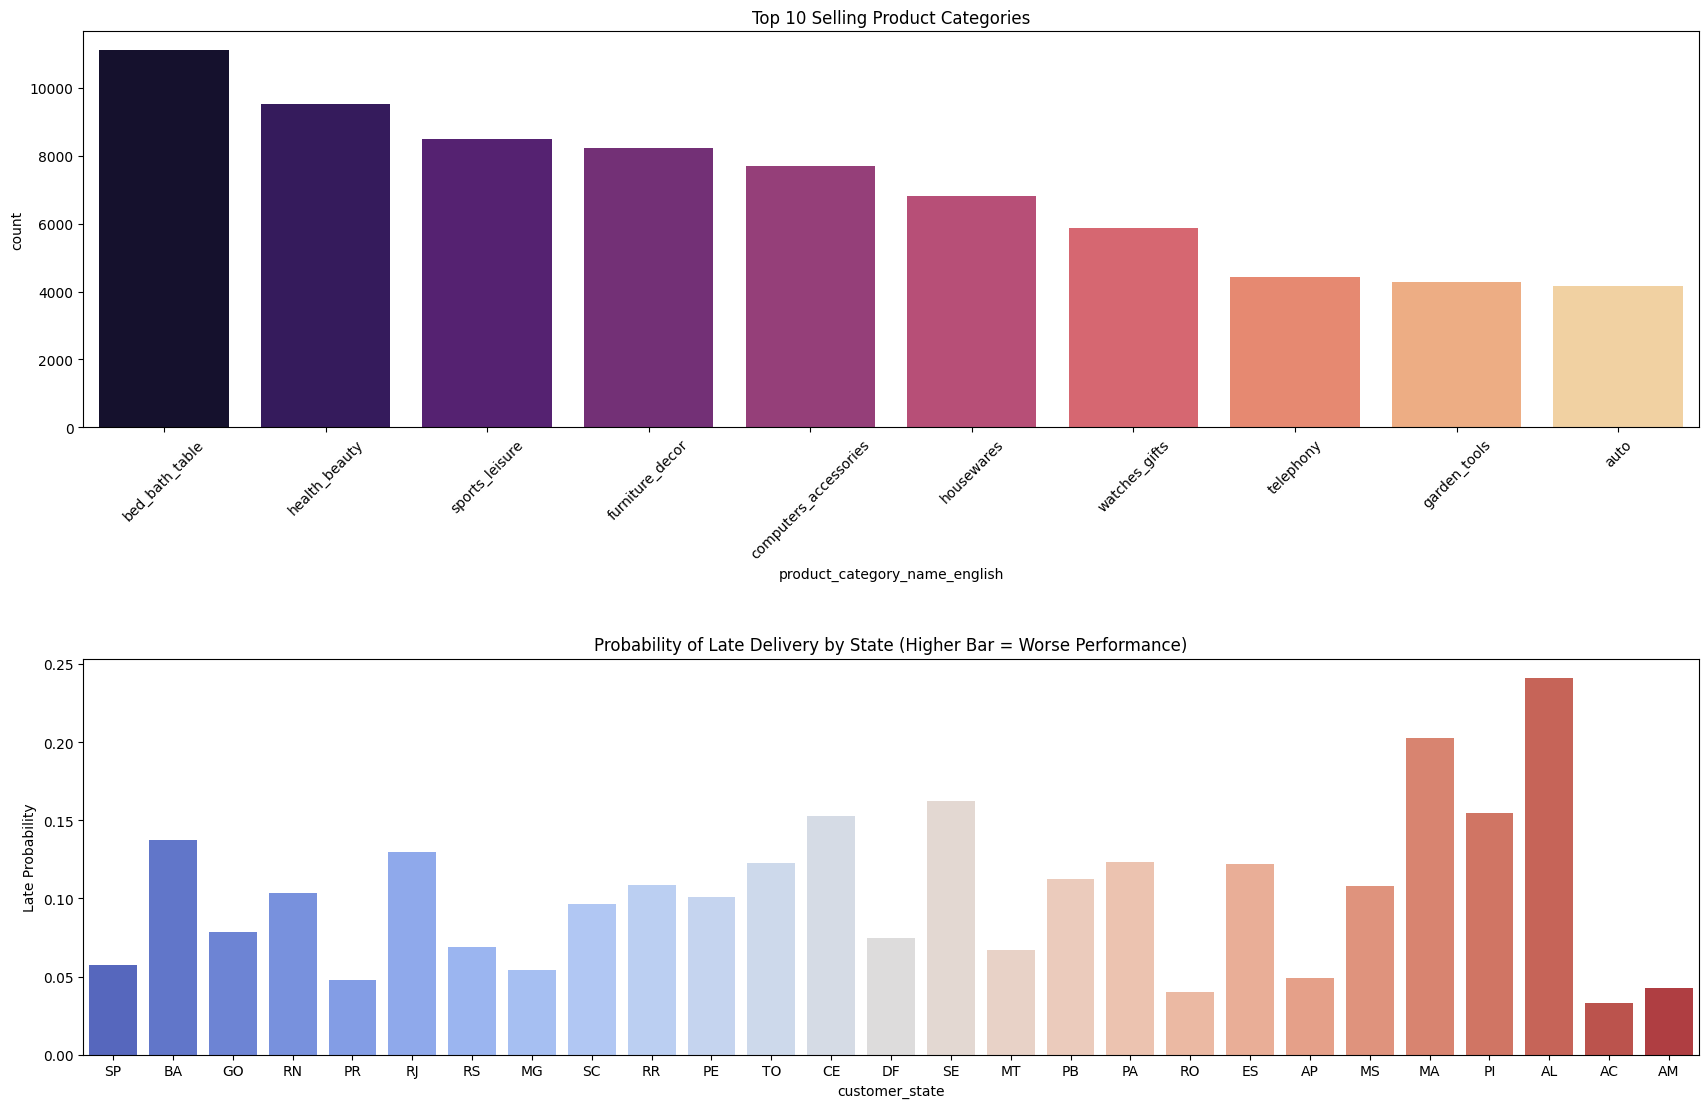

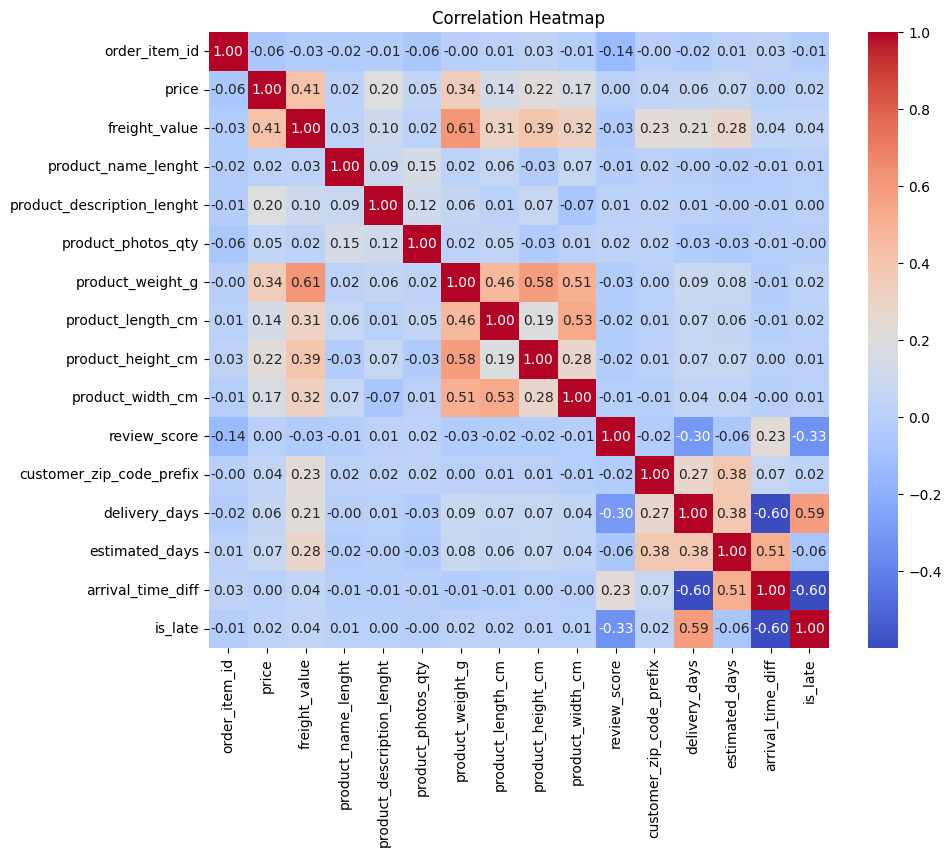

In [11]:
# Visualization Bivariate Analysis
# Canvas Setup
fig,ax = plt.subplots(2,1,figsize = (18,12))

# Graph 1: Top 10 Product Categories
top_products = df.product_category_name_english.value_counts().nlargest(10).index
sns.countplot(data=df[df.product_category_name_english.isin(top_products)],
              x='product_category_name_english',
              order=top_products,
              palette='magma',
              ax=ax[0])
ax[0].set_title('Top 10 Selling Product Categories')
ax[0].tick_params(axis='x',rotation=45)

# Graph 2: State Wise Late Delivery Analysis
sns.barplot(data=df, x='customer_state', y='is_late', ci=None, palette='coolwarm', ax=ax[1])
ax[1].set_title('Probability of Late Delivery by State (Higher Bar = Worse Performance)')
ax[1].set_ylabel('Late Probability')

plt.tight_layout(pad=4.0)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10,8))
# Only Numerical Columns Correlation
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [12]:
df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,review_creation_date,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,delivery_days,estimated_days,arrival_time_diff,is_late
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,...,2017-10-11,2017-10-12 03:43:48,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,8.0,15,7.0,0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,...,2018-08-08,2018-08-08 18:37:50,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,13.0,19,5.0,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,...,2018-08-18,2018-08-22 19:07:58,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,9.0,26,17.0,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,...,2017-12-03,2017-12-05 19:21:58,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,13.0,26,12.0,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,...,2018-02-17,2018-02-18 13:02:51,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2.0,12,9.0,0


In [13]:
# Module 1: Delivery Time Prediction (Regression)

#1. Outlier Removal - Let's Assume top 1% is slow deliveries those are noise (1% late due to some other factor like truck broke down etc.)
q99 = df.delivery_days.quantile(0.99)
print(f"99% orders are delivered within {q99} days.")

#Filter Data: Keep only those data where q99 equals or less than
df_clean = df[df.delivery_days <= q99].copy()
print(f"Original Shape: {df.shape}, Cleaned Shape: {df_clean.shape}")

#2. Selecting Features (X) and Target (Y): by doing this we will predict delivery_days
features = ['freight_value','product_weight_g','price','customer_state','product_category_name_english']

X = df_clean[features]
y = df_clean.delivery_days

#3. Encoding Categorical Variables
X = pd.get_dummies(X, columns=['customer_state','product_category_name_english'], drop_first=True)

print("Final Input Shape for Model:", X.shape)


99% orders are delivered within 45.0 days.
Original Shape: (110840, 37), Cleaned Shape: (109753, 37)
Final Input Shape for Model: (109753, 100)


In [14]:
# Missing Value Imputing
# 1. Checking for Missing Value
print("Missing values before fix:")
print(X.isnull().sum()[X.isnull().sum() > 0])

# 2. Fix: Fill Median in Missing Weight value
X = X.fillna(X.median())

# Verify Missing Value have been filled
print("\nMissing values after fix:")
print(X.isnull().sum().sum())


Missing values before fix:
product_weight_g    18
dtype: int64

Missing values after fix:
0


In [15]:
# Splitting train and test data
from sklearn.model_selection import train_test_split

# 80% Train Data and 20% Test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training Data: {X_train.shape}")
print(f"Testing Data: {X_test.shape}")


Training Data: (87802, 100)
Testing Data: (21951, 100)


In [16]:
# Model Training and Evaluation
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 1. Initialize Models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1) # n_jobs=-1 means use all CPU cores

# 2. Training
print('Training Linear Regression...')
lr_model.fit(X_train, y_train)

print("Training Random Forest (Wait For Sometime)...")
rf_model.fit(X_train, y_train)

# 3. Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# 4. Evaluation
def evaluate_model(name, y_actual, y_pred):
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)
    
    print(f"--- {name} Performance ---")
    print(f"RMSE (Error in Days): {rmse:.2f}")
    print(f"MAE (Avg Error in Days): {mae:.2f}")
    print(f"R2 Score (Variance Explained): {r2:.4f}\n")
    
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)


Training Linear Regression...
Training Random Forest (Wait For Sometime)...
--- Linear Regression Performance ---
RMSE (Error in Days): 6.74
MAE (Avg Error in Days): 4.94
R2 Score (Variance Explained): 0.2398

--- Random Forest Performance ---
RMSE (Error in Days): 6.31
MAE (Avg Error in Days): 4.37
R2 Score (Variance Explained): 0.3340



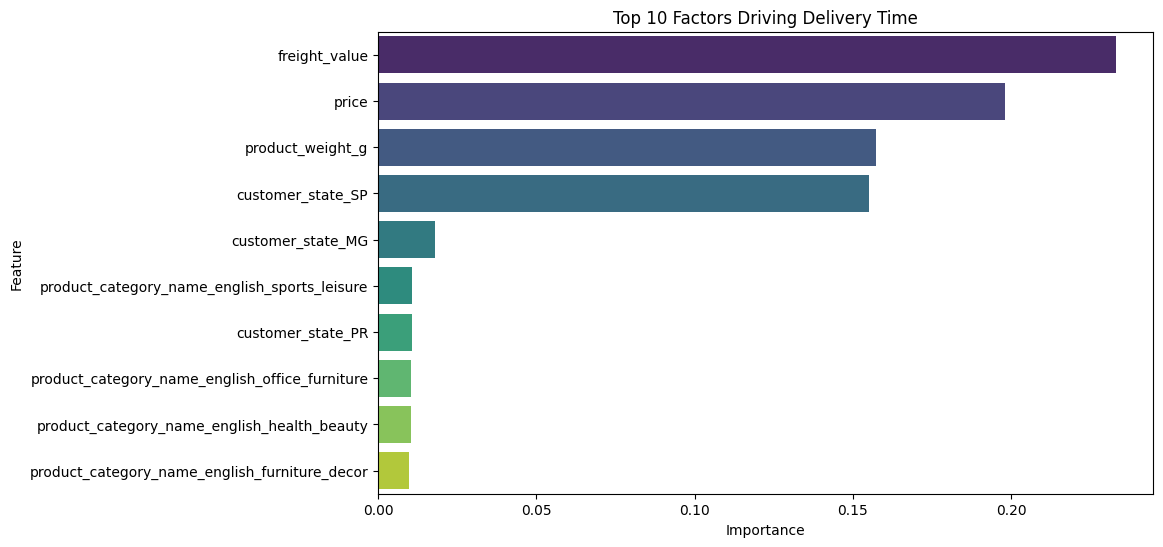

                                           Feature  Importance
0                                    freight_value    0.233199
2                                            price    0.198179
1                                 product_weight_g    0.157253
27                               customer_state_SP    0.155094
12                               customer_state_MG    0.017988
94    product_category_name_english_sports_leisure    0.010856
19                               customer_state_PR    0.010841
86  product_category_name_english_office_furniture    0.010463
72     product_category_name_english_health_beauty    0.010449
68   product_category_name_english_furniture_decor    0.009780


In [17]:
# Feature Importance
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a Dataframe so we can sort
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    "Importance": importances
})

# Sort Top 10 Important Features
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the Figure

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Top 10 Factors Driving Delivery Time')
plt.show()

print(feature_importance_df)


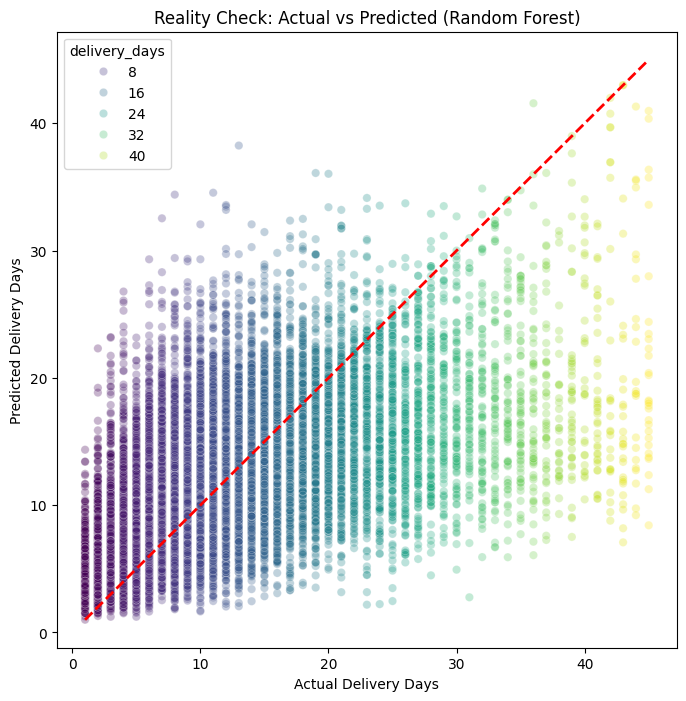

In [18]:
# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8,8))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.3,hue=y_test,palette='viridis')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()] ,'r--', lw=2)

plt.xlabel('Actual Delivery Days')
plt.ylabel('Predicted Delivery Days')
plt.title('Reality Check: Actual vs Predicted (Random Forest)')
plt.show()


In [19]:
# Module 2 Classification (is_late)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# 1. For Classification Change target variable before 'delivery_days' now 'is_late'(0 or 1)
y_class = df_clean.is_late

# 2. Split Data in train and test
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, random_state=42)

# 3. Check Class Imbalance
# Let's Check how much are late (1) vs On-time (0)
print("Training Data Imbalance:")
print(y_train_c.value_counts(normalize=True))

# scaling the data (Important for Logistic Regression)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_c)
X_test_scaled = scaler.transform(X_test_c)

# 4. Train Models
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train_c)

# Random Forest
rf_class = RandomForestClassifier(n_estimators=50, random_state=42)
rf_class.fit(X_train_c, y_train_c)

# 5. Predict
y_pred_log = log_model.predict(X_test_scaled)
y_pred_rfc = rf_class.predict(X_test_c)

print("\nModels Trained! Evaluation coming up next...")


Training Data Imbalance:
is_late
0    0.930514
1    0.069486
Name: proportion, dtype: float64

Models Trained! Evaluation coming up next...


--- Logistic Regression Report ---
Accuracy: 0.9263

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     20334
           1       0.00      0.00      0.00      1617

    accuracy                           0.93     21951
   macro avg       0.46      0.50      0.48     21951
weighted avg       0.86      0.93      0.89     21951



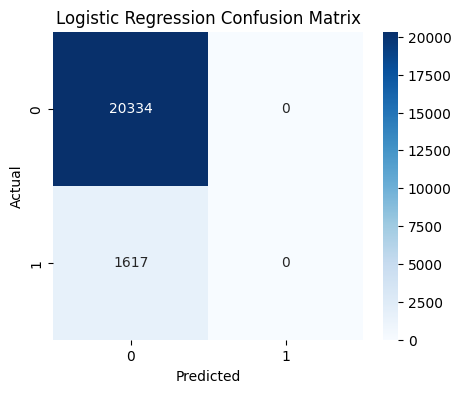

--- Random Forest Report ---
Accuracy: 0.9254

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     20334
           1       0.48      0.15      0.23      1617

    accuracy                           0.93     21951
   macro avg       0.71      0.57      0.59     21951
weighted avg       0.90      0.93      0.91     21951



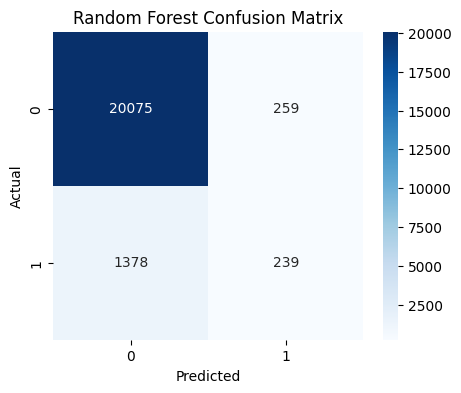

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
def evaluate_classification(model_name, y_test, y_pred):
    print(f"--- {model_name} Report ---")
    # Accuracy
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    # Detailed Report (Precision, Recall, F1)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
# Evaluate Models
evaluate_classification("Logistic Regression", y_test_c, y_pred_log)
evaluate_classification("Random Forest", y_test_c, y_pred_rfc)


In [21]:
# as we can see recall is very less due to this we can predict late delivery inacurately so to increase recall we will use SMOTE to add symmentic points
from imblearn.over_sampling import SMOTE

# SMOTE Apply on Training Data
print("Original Class Distribution:", y_train_c.value_counts())

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_c, y_train_c)

print("Resampled Class Distribution (After SMOTE):")
print(y_train_resampled.value_counts())

# 3. Let's Retrain Random Forest on Balanced data
print("\nRetraining Random Forest with SMOTE Data...")
rf_smote = RandomForestClassifier(n_estimators=50, random_state=42)
rf_smote.fit(X_train_resampled, y_train_resampled)

# 4. Evaluation
y_pred_smote = rf_smote.predict(X_test_c)

print("--- Random Forest (After SMOTE) Report ---")
print(classification_report(y_test_c, y_pred_smote))

# Compare Recall
from sklearn.metrics import recall_score
old_recall = 0.15
new_recall = recall_score(y_test_c, y_pred_smote)
print(f"Recall Improvement: {old_recall:.2f} -> {new_recall:.2f}")


Original Class Distribution: is_late
0    81701
1     6101
Name: count, dtype: int64
Resampled Class Distribution (After SMOTE):
is_late
1    81701
0    81701
Name: count, dtype: int64

Retraining Random Forest with SMOTE Data...
--- Random Forest (After SMOTE) Report ---
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     20334
           1       0.36      0.17      0.23      1617

    accuracy                           0.92     21951
   macro avg       0.65      0.57      0.59     21951
weighted avg       0.89      0.92      0.90     21951

Recall Improvement: 0.15 -> 0.17


In [22]:
# still the recall is not convencing because it just increase score by only 0.2 so we will use XGBOOST + Class Weights

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import recall_score, accuracy_score ,confusion_matrix

# Strategy 1: Random Forest with Aggressive Weights
# {0: 1, 1: 10} means: 1 Late order miss = 10 On-time order miss (penalty)
print("Training Random Forest with Aggressive Weights...")
rf_weighted = RandomForestClassifier(n_estimators=50, class_weight={0: 1, 1: 10} ,random_state=42)
rf_weighted.fit(X_train_c, y_train_c) # we will use original data here not one with SMOTE


# Strategy 2: Gradient Boosting (Sklearn's alternative to XGBoost)
# in this there is no direct class_weoght so we will run it default
# this will tell that positive class (1) is how much important
print("Training Gradient Boosting (Sklearn)...")
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train_c, y_train_c)

def quick_evaluate(name, model, X_test, y_test):
    preds = model.predict(X_test)
    rec = recall_score(y_test, preds)
    acc = accuracy_score(y_test, preds)
    
    print(f"--- {name} Results ---")
    print(f"Accuracy: {acc:.2f}")
    print(f"Recall (Late Orders Captured): {rec:.2f}")
    
    # Let's print Confusion Matrix too so we can see exact numbers
    cm = confusion_matrix(y_test, preds)
    print(f"Confusion Matrix:\n{cm}")
    print("-" * 30)
    
quick_evaluate("Random Forest (Aggressive Weighted)", rf_weighted, X_test_c, y_test_c)
quick_evaluate("Gradient Boosting (Sklearn)", gb_model, X_test_c, y_test_c)


Training Random Forest with Aggressive Weights...
Training Gradient Boosting (Sklearn)...
--- Random Forest (Aggressive Weighted) Results ---
Accuracy: 0.91
Recall (Late Orders Captured): 0.20
Confusion Matrix:
[[19717   617]
 [ 1300   317]]
------------------------------
--- Gradient Boosting (Sklearn) Results ---
Accuracy: 0.93
Recall (Late Orders Captured): 0.01
Confusion Matrix:
[[20328     6]
 [ 1602    15]]
------------------------------


Weight for On-Time (0): 0.54
Weight for Late (1): 7.20

Training Weighted Gradient Boosting...
--- Weighted Gradient Boosting Results ---
Accuracy: 0.68
Recall (Late Captured): 0.53
Confusion Matrix:
[[14098  6236]
 [  756   861]]


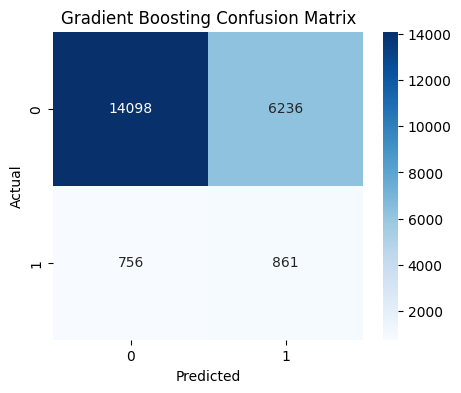

In [23]:
# we are now adding sample weights because we are using gradient boost and we got 0.01 recall which is too much less so we will compute weights
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import recall_score, accuracy_score ,confusion_matrix
import matplotlib.pyplot as plt

# Auto Calculate weights based on imbalance
# 'balanced' mode will check that Class 1 is less, then it will increase its weights
train_weights = compute_sample_weight(class_weight='balanced', y=y_train_c)

print(f"Weight for On-Time (0): {train_weights[y_train_c==0][0]:.2f}")
print(f"Weight for Late (1): {train_weights[y_train_c==1][0]:.2f}")

# 2. Train Gradient Boosting with weights
print("\nTraining Weighted Gradient Boosting...")
# max_depth=5 will capture complex patterns
gb_weighted = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# here is real magic -> we are passing sample_weight
gb_weighted.fit(X_train_c, y_train_c, sample_weight=train_weights)

# 3. Evaluate
preds_w = gb_weighted.predict(X_test_c)

print("--- Weighted Gradient Boosting Results ---")
print(f"Accuracy: {accuracy_score(y_test_c, preds_w):.2f}")
print(f"Recall (Late Captured): {recall_score(y_test_c, preds_w):.2f}")

# Confusion Matrix
print(f"Confusion Matrix:\n{confusion_matrix(y_test_c, preds_w)}")

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test_c, preds_w), annot=True, fmt='d', cmap='Blues')
plt.title(f'Gradient Boosting Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Model Training Result
### Recall: as you can see we have increased our recall to 0.53 which is great.
### Trade-off (The Cost): accuracy has been dropped from 93% to 68% but it's acceptable in this scenario

ROC-AUC Score: 0.6464 (Higher is Better, 0.5 is Random)


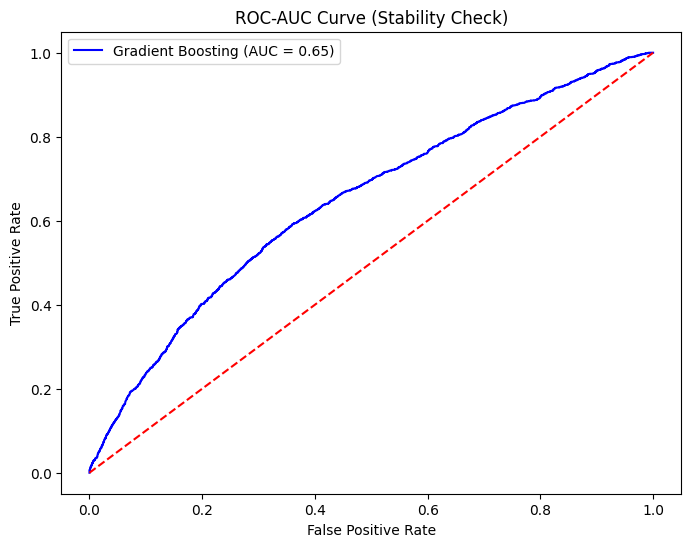

Model Saved Successfully as 'delivery_late_model.pkl' in models Folder!


In [24]:
# Final Step
from sklearn.metrics import roc_auc_score, roc_curve
import joblib
import os

# Check stability: ROC - AUC Curve
# 1. Plot ROC-AUC Curve
# let's check probability of getting late order
y_pred_proba = gb_weighted.predict_proba(X_test_c)[:, 1]

# Calculate Scores
auc_score = roc_auc_score(y_test_c, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test_c, y_pred_proba)

print(f"ROC-AUC Score: {auc_score:.4f} (Higher is Better, 0.5 is Random)")

# Plotting
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'Gradient Boosting (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle = '--') # Random Guess Line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve (Stability Check)')
plt.legend()
plt.show()

# Save Final Model
os.makedirs('../models', exist_ok=True)
joblib.dump(gb_weighted, '../models/delivery_late_model.pkl')
print("Model Saved Successfully as 'delivery_late_model.pkl' in models Folder!")
